In [ ]:
import pandas as pd
import sys
import os
from os import listdir
os.chdir("c:/Users/Robert/Documents/Projekte/dev/sport_betting/")
import config as CONFIG
pd.set_option('display.max_columns', 500)

In [ ]:
%load_ext autoreload
%autoreload 2
from src.data.provide_data import get_model_data
from src.models.evaluate import custom_classification_report, custom_lazy_report



In [ ]:
df = pd.read_csv("data/processed/model_data_deployment.csv",index_col=0)


In [ ]:
df['set'] = "train"
df.loc[df.year > 2020, 'set'] = "valid"
df.loc[df.year > 2022, 'set'] = "test"

# df = df.drop(["B365_Opponent","B365_Draw","B365_Team",'B365_Team_odd_pred', 'B365_opponent_odd_pred', 'B365_Team_draw_pred'],axis=1)

In [ ]:
df.head()

In [ ]:
train_df = df[df['set'] == 'train']
train_df.drop('set',axis=1).to_csv(CONFIG.DATA_FOLDER_PROCESSED+"train/model_data.csv")

valid_df = df[df['set'] == 'valid']
valid_df.drop('set',axis=1).to_csv(CONFIG.DATA_FOLDER_PROCESSED+"valid/model_data.csv")

test_df = df[df['set'] == 'test']
test_df.drop('set',axis=1).to_csv(CONFIG.DATA_FOLDER_PROCESSED+"test/model_data.csv")



In [ ]:
X_train, y_train = get_model_data(filename = "train",model_data="model_data",use_categories=False)
X_valid, y_valid = get_model_data(filename = "valid",model_data="model_data",use_categories=False)
X_test, y_test = get_model_data(filename = "test",model_data="model_data",use_categories=False)

cat = [X_train.columns.get_loc(i) for i in ["Team","Div","Opponent"] if i in X_train.columns] 
cat

In [ ]:
features = X_train.columns

In [ ]:
if True:
    from sklearn.preprocessing import StandardScaler

    # Initialize scaler object
    scaler = StandardScaler()

    # Fit scaler on training data
    scaler.fit(X_train)

    # Scale training and test data
    X_train = scaler.transform(X_train)

    X_test = scaler.transform(X_test)
    X_valid = scaler.transform(X_valid)

# Baseline Model

In [ ]:
from lazypredict.Supervised import LazyClassifier

lazy_clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = lazy_clf.fit(X_train, X_valid, y_train, y_valid)
models

In [ ]:
custom_lazy_report(X_test,y_test,lazy_clf)

# XGBoost

In [32]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pickle

# Define the parameter grid to search over
params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'min_child_weight': 10,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.005,
    'reg_lambda': 0.01,
    'scale_pos_weight': 1,
    'n_estimators': 100,
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'aucpr',
    #'enable_categorical':True
        # You can change the evaluation metric as needed
}

# Create an XGBClassifier model
clf = XGBClassifier(**params)  # Use **params to pass the dictionary as keyword arguments

# Fit the GridSearchCV object to the training data
clf.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV (if you're using GridSearchCV)

# Call the custom_classification_report function
custom_classification_report(X=X_train, y=y_train, model=clf)
custom_classification_report(X=X_valid, y=y_valid, model=clf)
custom_classification_report(X=X_test, y=y_test, model=clf)

# Save the XGBoost model to a pickle file
with open(CONFIG.DATA_FOLDER_MODELS + 'xgb.pkl', 'wb') as f:
    pickle.dump(clf, f)

fi = pd.DataFrame() 
fi['features'] = features
fi['importance'] = clf.feature_importances_
fi['importance'] = fi['importance']/sum(fi['importance'])
fi.sort_values(by='importance',ascending=False).head(10)


              precision    recall  f1-score   support

       False       0.70      0.90      0.79     69984
        True       0.67      0.35      0.46     40428

    accuracy                           0.70    110412
   macro avg       0.69      0.62      0.62    110412
weighted avg       0.69      0.70      0.67    110412

AUC 0.733
              precision    recall  f1-score   support

       False       0.69      0.90      0.78     16936
        True       0.64      0.32      0.43      9886

    accuracy                           0.68     26822
   macro avg       0.67      0.61      0.60     26822
weighted avg       0.68      0.68      0.65     26822

AUC 0.703
              precision    recall  f1-score   support

       False       0.69      0.89      0.78      3929
        True       0.64      0.34      0.44      2347

    accuracy                           0.68      6276
   macro avg       0.67      0.61      0.61      6276
weighted avg       0.67      0.68      0.65      6276


,features,importance
11,Avg_Team,0.30
27,WH_Team_odd_pred,0.14
9,Max_Team,0.11
3,WH_Team,0.10
10,Min_Team,0.06
16,Avg_Opponent,0.04
4,IW_Opponent,0.02
24,IW_Team_odd_pred,0.02
6,IW_Team,0.02
14,Max_Opponent,0.01


In [29]:
preds_test = pd.Series(clf.predict_proba(X_test)[:,1])


<Axes: >

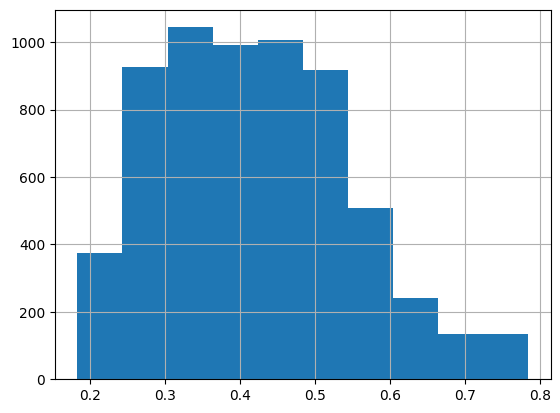

In [31]:
preds_test.hist()

# LGM

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV


# Define the parameter grid to search over
params = {'learning_rate': 0.01007397282357752, 'num_leaves': 12, 'max_depth': 3, 'min_child_samples': 6}

# Create a LGBMClassifier model
clf = LGBMClassifier(**params)  # Use **params to pass the dictionary as keyword arguments

# Fit the GridSearchCV object to the training data
clf.fit(X_train, y_train,eval_metric='recall')

# Print the best hyperparameters found by GridSearchCV

# Call the custom_classification_report function
custom_classification_report(X=X_train, y=y_train, model=clf)
custom_classification_report(X=X_valid, y=y_valid, model=clf)
custom_classification_report(X=X_test, y=y_test, model=clf)

import pickle

pickle.dump(clf, open(CONFIG.DATA_FOLDER_MODELS + 'lgb.pkl', 'wb'))

fi = pd.DataFrame() 
fi['features'] = features
fi['importance'] = clf.booster_.feature_importance(importance_type='gain')  
fi['importance'] = fi['importance']/sum(fi['importance'])
fi.sort_values(by='importance',ascending=False).head(10)

## Gridsearch für bestes Baseline Model

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'learning_rate': [0.01, 0.1, 1.0],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 4, 5]
}
params = {'learning_rate': 0.01007397282357752, 'num_leaves': 12, 'max_depth': 3, 'min_child_samples': 6}
# Create a LGBMClassifier model
clf = LGBMClassifier(params)

# Create a GridSearchCV object to perform grid search
grid_search = GridSearchCV(clf, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found by GridSearchCV
print("Best hyperparameters:", grid_search.best_params_)
custom_classification_report(X = X_test,y = y_test,model = grid_search)


In [ ]:
import optuna
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

# Define an objective function to optimize
def objective(trial):
    # Define the search space for hyperparameters
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
    }

    # Split your data into training and validation sets
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)

    # Specify the number of boosting rounds
    num_boost_round = 10000

    # Initialize variables for early stopping
    early_stopping_rounds = 100
    early_stopping_counter = 0
    best_logloss = float('inf')

    # Train the LightGBM model
    clf = lgb.LGBMClassifier(**params, n_estimators=num_boost_round)
    clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

    # Make predictions on the validation set
    val_pred = clf.predict_proba(X_valid, num_iteration=clf.best_iteration_)[:, 1]
    logloss = log_loss(y_valid, val_pred)

    if logloss < best_logloss:
        best_logloss = logloss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_rounds:
            return best_logloss  # Early stopping

    return best_logloss

# Create a study object and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Get the best hyperparameters
best_params = study.best_params

# Split your data into training and validation sets
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a LightGBM classifier with the best hyperparameters
clf = lgb.LGBMClassifier(**best_params, n_estimators=100)  # You can specify a large number of estimators
clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100)

# Make predictions on the validation set
y_pred = clf.predict(X_valid)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_valid, y_pred)
print("Validation Accuracy:", accuracy)


# Transformer

## Pretrainer

In [ ]:

import torch

from pytorch_tabnet.pretraining import TabNetPretrainer

# Define pretrainer model architecture
pretrainer = TabNetPretrainer(
optimizer_fn=torch.optim.Adam,
optimizer_params=dict(lr=2e-2),
mask_type="entmax"
)

# Train pretrainer model on training data
pretrainer.fit(
    X_train=X_train,
    eval_set=[X_valid],
    max_epochs=1000,
    patience=30,
    pretraining_ratio=0.8,
    batch_size= 64
)


## Modellfitting

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

# Define hyperparameters
n_d = 8
n_a = 8
n_steps = 3
gamma = 1
lambda_sparse = 0.001
lr = 0.0001
batch_size = 16
max_epochs = 150

# Create TabNet classifier
clf = TabNetClassifier(n_d=n_d, n_a=n_a, cat_dims=cat,n_steps=n_steps, gamma=gamma, lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=lr), mask_type='entmax', device_name='cuda' if torch.cuda.is_available() else 'cpu')
# Train TabNet classifier
clf.fit(X_train=X_train, y_train=y_train,     eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'], eval_metric=['auc','balanced_accuracy'],batch_size=batch_size, max_epochs=max_epochs, patience=0)
# from_unsupervised=pickle.load(open('tabnet.pkl', 'rb'))

import pickle
pickle.dump(clf, open('tabnet.pkl', 'wb'))

In [ ]:
import pickle
pickle.dump(clf, open('tabnet.pkl', 'wb'))


In [ ]:
pickle.load(open('tabnet.pkl', 'rb'))

## Evaluierung

In [ ]:
from matplotlib import pyplot as plt

plt.plot(clf.history['loss'], label='Validation Loss')
plt.plot(clf.history['valid_auc'], label='AUC')
plt.plot(clf.history['valid_balanced_accuracy'], label='Accuracy')

plt.legend()
plt.show()

from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
r = classification_report(y_pred=y_pred,y_true=y_test)
print(r)

## Erklärbarkeit

In [ ]:
f_i = pd.Series(clf.feature_importances_)
f_i.index = features
f_i.sort_values(ascending=False)

In [ ]:
"BW_opponent_odd_pred","B365_Opponent","Avg_Opponent","IW_Team","Span_Draw"      

In [ ]:
sum(f_i>0.01)

#  Hypertune

In [ ]:
import optuna
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, brier_score_loss

def load_dataset():
    # Load your dataset here
    # Replace this with your dataset loading code
    # X and y should be your feature and target variables
    pass

def objective(trial):
    # Define the hyperparameters to optimize
    shrink_threshold = trial.suggest_float("shrink_threshold", 0.0, 1.0)
    
    X_train, y_train = get_model_data(filename = "Train")
    X_valid, y_valid = get_model_data(filename = "Valid")
    X_test, y_test = get_model_data(filename = "Test")
    
    # Create and train the NearestCentroid classifier with the suggested parameters
    clf = NearestCentroid(shrink_threshold=shrink_threshold)
    clf.fit(X_train, y_train)
    
    # Make predictions on the validation set
    y_pred = clf.predict(X_valid)
    
    # Calculate the accuracy of the model
    score = brier_score_loss(y_valid, y_pred)
    
    return brier_score_loss

if __name__ == "__main__":
    # Load your dataset
    
    # Specify the SQLite database file for the study
    study_name = "neareast_centroid_optimization.db"
    study = optuna.create_study(direction="minimize", study_name=study_name)

    # Optimize the study
    study.optimize(objective, n_trials=100)  # You can adjust the number of trials

    # Get the best parameters and their corresponding accuracy
    best_params = study.best_params
    best_accuracy = study.best_value

    print("Best Parameters:", best_params)
    print("Best Accuracy:", best_accuracy)

    # # Save the study to the specified SQLite database file
    # study.trials_dataframe().to_sql(study_name, "sqlite:///{}".format(study_name), if_exists="replace")


In [ ]:
    clf = NearestCentroid(shrink_threshold=0.95)
    clf.fit(X_train, y_train)

In [ ]:
clf.predict(X_test)